In [ ]:
 #Download and preprocess S&P 500 data
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

# Fetch data for VIX
viz = yf.Ticker("^VIX")
viz_data = viz.history(start="2005-01-04", end ="2015-01-04")

# Fetch data for S&P 500
sp = yf.Ticker("^GSPC")
sp_data = sp.history(start="2005-01-04", end ="2015-01-04")

# Fetch data for Treasury Bond Futures
zb = yf.Ticker("ZB=F")
zb_data = zb.history(start="2005-01-04", end ="2015-01-04")


# Convert index to just date
viz_data.index = pd.to_datetime(viz_data.index.date)
sp_data.index = pd.to_datetime(sp_data.index.date)
zb_data.index = pd.to_datetime(zb_data.index.date)

# Reset index to create a Date column
viz_data = viz_data.reset_index()
sp_data = sp_data.reset_index()
zb_data = zb_data.reset_index()

# Rename columns for clarity
viz_data = viz_data[["index", "Close"]].rename(columns={"index": "Date", "Close": "vix_close"})
sp_data = sp_data[["index", "Close"]].rename(columns={"index": "Date", "Close": "sp_close"})
zb_data = zb_data[["index", "Close"]].rename(columns={"index": "Date", "Close": "zb_close"})

# Merge the data on the Date column
combined_data = pd.merge(viz_data, sp_data, on="Date", how="inner")
combined_data = pd.merge(combined_data, zb_data, on="Date", how="inner")
# Add moving average columns
combined_data['ema_fast'] = combined_data['sp_close'].ewm(span=6, adjust=False).mean()
combined_data['ema_slow'] = combined_data['sp_close'].ewm(span=30, adjust=False).mean()
combined_data['macd'] = combined_data['ema_fast'] - combined_data['ema_slow']
combined_data['signal_line'] = combined_data['macd'].ewm(span=9, adjust=False).mean()
combined_data['macd_histogram'] = combined_data['macd'] - combined_data['signal_line']




# Drop the last row since we can't determine its target
combined_data = combined_data.dropna()

# Select features
features = combined_data[["vix_close", "sp_close","zb_close",'macd','signal_line', 'macd_histogram']].values

spy = combined_data["sp_close"].values

def prepare_market_data(data, features, window_size=3):

    X, y, dates = [], [], []
    for i in range(len(features) - window_size):
        row = [r for r in features[i: i + window_size]]
        X.append(row)
        label = (spy[i+window_size])
        y.append(label)
        dates.append(data["Date"].iloc[i + window_size])

    return np.array(X), np.array(y).reshape(-1,1), np.array(dates)



window_size = 3
X, y, dates = prepare_market_data(combined_data,features, window_size=window_size)


print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")



X shape: (2508, 3, 6)
y shape: (2508, 1)


In [ ]:
print("First sample X:", X[0])
print("First target y:", y[0])
print("First date:", dates[0])

First sample X: [[ 1.39799995e+01  1.18805005e+03  1.11781303e+02  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 1.40900002e+01  1.18373999e+03  1.12062500e+02 -9.53377016e-01
  -1.90675403e-01 -7.62701613e-01]
 [ 1.35799999e+01  1.18789001e+03  1.12093803e+02 -6.54874654e-01
  -2.83515253e-01 -3.71359401e-01]]
First target y: [1186.18994141]
First date: 2005-01-07 00:00:00


In [ ]:
q_80 = int(len(X) * 0.6)
q_90 = int(len(X) * 0.8)

X_train, y_train = X[:q_80], y[:q_80]
X_val, y_val = X[q_80:q_90], y[q_80:q_90]
X_test, y_test = X[q_90:], y[q_90:]

X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((1504, 3, 6), (1504, 1), (502, 3, 6), (502, 1), (502, 3, 6), (502, 1))

In [ ]:

def preprocess(X, mean, std):
    X[:, :, 0] = (X[:, :, 0] - mean) / std
    return X

sp_training_mean = np.mean(X_train[:, :, 0])
sp_training_std = np.std(X_train[:, :, 0])

X_train = preprocess(X_train, sp_training_mean, sp_training_std)
X_val = preprocess(X_val, sp_training_mean, sp_training_std)
X_test = preprocess(X_test, sp_training_mean, sp_training_std)

In [ ]:
class MultivariateLSTM:
  #define functions
    def __init__(self, input_size=3, hidden_size=30, learning_rate=0.001):
        # Initialize weights and biases
        self.Wf = np.random.randn(hidden_size, input_size + hidden_size) * 0.01
        self.bf = np.zeros((hidden_size, 1))

        self.Wi = np.random.randn(hidden_size, input_size + hidden_size) * 0.01
        self.bi = np.zeros((hidden_size, 1))

        self.Wc = np.random.randn(hidden_size, input_size + hidden_size) * 0.01
        self.bc = np.zeros((hidden_size, 1))

        self.Wo = np.random.randn(hidden_size, input_size + hidden_size) * 0.01
        self.bo = np.zeros((hidden_size, 1))

        self.Wy = np.random.randn(1, hidden_size) * 0.01
        self.by = np.zeros((1, 1))

        self.hidden_size = hidden_size
        self.learning_rate = learning_rate
        self.input_size = input_size

   #activation functions
    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def sigmoid_derivative(self, x):
        return x * (1 - x)

    def tanh_derivative(self, x):
        return 1 - x**2

    def forward(self, X):

        T = X.shape[0]

        # Initialize hidden states
        h = np.zeros((T + 1, self.hidden_size, 1))
        c = np.zeros((T + 1, self.hidden_size, 1))

        # Stores for backpropagation
        self.cache = {}
        self.cache['X'] = X
        self.cache['h'] = h
        self.cache['c'] = c

        # Forward pass
        for t in range(T):
            # Concatenate previous hidden state and current input
            concat = np.concatenate([h[t-1].flatten() if t > 0 else np.zeros(self.hidden_size),
                                     X[t].reshape(-1)])

            # Forget gate
            forget_gate = self.sigmoid(np.dot(self.Wf, concat).reshape(-1, 1) + self.bf)

            # Input gate
            input_gate = self.sigmoid(np.dot(self.Wi, concat).reshape(-1, 1) + self.bi)

            # Candidate cell state
            c_candidate = np.tanh(np.dot(self.Wc, concat).reshape(-1, 1) + self.bc)

            # Cell state update (ensure correct shape)
            c[t] = forget_gate * (c[t-1] if t > 0 else np.zeros((self.hidden_size, 1))) + \
                   input_gate * c_candidate

            # Output gate
            output_gate = self.sigmoid(np.dot(self.Wo, concat).reshape(-1, 1) + self.bo)

            # Hidden state
            h[t] = output_gate * np.tanh(c[t])

            # Store gates for backpropagation
            self.cache[f'forget_gate_{t}'] = forget_gate
            self.cache[f'input_gate_{t}'] = input_gate
            self.cache[f'output_gate_{t}'] = output_gate
            self.cache[f'c_candidate_{t}'] = c_candidate

        # Final prediction
        output = np.dot(self.Wy, h[T-1]) + self.by

        self.cache['output'] = output
        return output.flatten()[0]

#backpropagation
    def backward(self, dy):
        # Retrieve stored values
        X = self.cache['X']
        h = self.cache['h']
        c = self.cache['c']
        T = X.shape[0]

        # Initialize gradients
        dWf = np.zeros_like(self.Wf)
        dbf = np.zeros_like(self.bf)
        dWi = np.zeros_like(self.Wi)
        dbi = np.zeros_like(self.bi)
        dWc = np.zeros_like(self.Wc)
        dbc = np.zeros_like(self.bc)
        dWo = np.zeros_like(self.Wo)
        dbo = np.zeros_like(self.bo)
        dWy = np.zeros_like(self.Wy)
        dby = np.zeros_like(self.by)

        # Gradient of output layer
        dby = dy
        dWy = dy * h[T-1].T

        # Initialize gradients for hidden state and cell state
        dh_next = np.dot(dy, self.Wy).flatten()
        dc_next = np.zeros((self.hidden_size, 1))

        # Backpropagate through time
        for t in reversed(range(T)):
            # Retrieve cached values for this timestep
            forget_gate = self.cache[f'forget_gate_{t}']
            input_gate = self.cache[f'input_gate_{t}']
            output_gate = self.cache[f'output_gate_{t}']
            c_candidate = self.cache[f'c_candidate_{t}']

            # Concatenate input
            concat = np.concatenate([h[t-1].flatten() if t > 0 else np.zeros(self.hidden_size),
                                     X[t].reshape(-1)])

            # Output gate
            do_gate = dh_next.reshape(-1, 1) * np.tanh(c[t]) * self.sigmoid_derivative(output_gate)
            dWo += np.outer(do_gate.flatten(), concat)
            dbo = do_gate

            # cell state
            dc = dh_next.reshape(-1, 1) * output_gate * self.tanh_derivative(np.tanh(c[t])) + dc_next

            # candidate cell state
            dc_candidate = dc * input_gate * self.tanh_derivative(c_candidate)
            dWc += np.outer(dc_candidate.flatten(), concat)
            dbc = dc_candidate

            # input gate
            di_gate = dc * c_candidate * self.sigmoid_derivative(input_gate)
            dWi += np.outer(di_gate.flatten(), concat)
            dbi = di_gate

            # forget gate
            df_gate = dc * (c[t-1] if t > 0 else np.zeros((self.hidden_size, 1))) * \
                      self.sigmoid_derivative(forget_gate)
            dWf += np.outer(df_gate.flatten(), concat)
            dbf = df_gate

            # Prepare for next iteration
            dh_next = (np.dot(self.Wf.T, df_gate) +
                       np.dot(self.Wi.T, di_gate) +
                       np.dot(self.Wc.T, dc_candidate) +
                       np.dot(self.Wo.T, do_gate))[:self.hidden_size]

            dc_next = dc * forget_gate

        # Clip gradients
        for grad in [dWf, dWi, dWc, dWo, dWy,
                     dbf, dbi, dbc, dbo, dby]:
            np.clip(grad, -1, 1, out=grad)

        # Update weights
        self.Wf -= self.learning_rate * dWf
        self.bf -= self.learning_rate * dbf
        self.Wi -= self.learning_rate * dWi
        self.bi -= self.learning_rate * dbi
        self.Wc -= self.learning_rate * dWc
        self.bc -= self.learning_rate * dbc
        self.Wo -= self.learning_rate * dWo
        self.bo -= self.learning_rate * dbo
        self.Wy -= self.learning_rate * dWy
        self.by -= self.learning_rate * dby

    #train
    def train(self, X_train, y_train, epochs=150, batch_size=32):
        train_losses = []

        for epoch in range(epochs):
            total_loss = 0


            indices = np.random.permutation(len(X_train))
            X_train = X_train[indices]
            y_train = y_train[indices]

            # Mini-batch training
            for i in range(0, len(X_train), batch_size):
                batch_X = X_train[i:i+batch_size]
                batch_y = y_train[i:i+batch_size]

                batch_loss = 0
                for j in range(len(batch_X)):
                    # Forward pass
                    prediction = self.forward(batch_X[j])

                    # Compute loss
                    loss = (prediction - batch_y[j]) ** 2
                    batch_loss += loss

                    # Backward pass
                    self.backward(prediction - batch_y[j])

                # Average  loss
                batch_loss /= len(batch_X)
                total_loss += batch_loss

            # Average epoch loss
            total_loss /= (len(X_train) // batch_size)
            train_losses.append(total_loss)

            # Print loss every 10 epochs
            if epoch % 10 == 0:
                print(f'Epoch {epoch}, Loss: {total_loss}')

        return train_losses

# predict function
    def predict(self, X):
        """Predict using the trained LSTM network"""
        predictions = []

        for x in X:
            prediction = self.forward(x)
            predictions.append(prediction)

        return np.array(predictions)



# Prepare data
X, y, dates = prepare_market_data(combined_data, features,window_size=3)

# Split data
#q_80 = int(len(X) * 0.8)
#q_90 = int(len(X) * 0.9)

#X_train, y_train = X[:q_80], y[:q_80]
#X_val, y_val = X[q_80:q_90], y[q_80:q_90]
#X_test, y_test = X[q_90:], y[q_90:]

dates_train = dates[:q_80]
dates_val = dates[q_80:q_90]
dates_test = dates[q_90:]

# Initialize and train Multivariate LSTM
lstm = MultivariateLSTM(input_size=6, hidden_size=128, learning_rate=0.001)
train_losses = lstm.train(X_train, y_train, epochs=200)

# Predict on train, val, and test sets
train_predictions = lstm.predict(X_train)
val_predictions = lstm.predict(X_val)
test_predictions = lstm.predict(X_test)
#accuracy_test = lstm.calculate_accuracy(y_test, test_predictions)

Epoch 0, Loss: [1371859.70544908]
Epoch 10, Loss: [19528.70720222]
Epoch 20, Loss: [2015.64905554]
Epoch 30, Loss: [1628.05316967]
Epoch 40, Loss: [1485.85406593]
Epoch 50, Loss: [1399.50762463]
Epoch 60, Loss: [1466.50800033]
Epoch 70, Loss: [1264.27511151]
Epoch 80, Loss: [1297.52145987]
Epoch 90, Loss: [1149.86734423]
Epoch 100, Loss: [1098.0003625]
Epoch 110, Loss: [1179.64446596]
Epoch 120, Loss: [1203.76320583]
Epoch 130, Loss: [1084.25498669]
Epoch 140, Loss: [1061.05698349]
Epoch 150, Loss: [1153.56055222]
Epoch 160, Loss: [1052.80187554]
Epoch 170, Loss: [1058.60413242]
Epoch 180, Loss: [1025.75824267]
Epoch 190, Loss: [1059.4819657]


In [ ]:
# Print the first 10 results for all

print("Training Set Results:")
for i in range(10):
    print(f"Predicted: {train_predictions[i]:.2f}, Actual: {y_train[i][0]:.2f}")


print("\nValidation Set Results:")
for i in range(10):
    print(f"Predicted: {val_predictions[i]:.2f}, Actual: {y_val[i][0]:.2f}")


print("\nTest Set Results:")
for i in range(10):
    print(f"Predicted: {test_predictions[i]:.2f}, Actual: {y_test[i][0]:.2f}")


Training Set Results:
Predicted: 1209.69, Actual: 1186.19
Predicted: 1208.64, Actual: 1190.25
Predicted: 1209.12, Actual: 1182.99
Predicted: 1206.42, Actual: 1187.70
Predicted: 1206.45, Actual: 1177.45
Predicted: 1205.89, Actual: 1184.52
Predicted: 1205.84, Actual: 1195.98
Predicted: 1206.28, Actual: 1184.63
Predicted: 1205.61, Actual: 1175.41
Predicted: 1205.71, Actual: 1167.87

Validation Set Results:
Predicted: 1244.91, Actual: 1276.56
Predicted: 1285.89, Actual: 1273.85
Predicted: 1251.40, Actual: 1271.50
Predicted: 1246.07, Actual: 1269.75
Predicted: 1252.21, Actual: 1274.48
Predicted: 1260.70, Actual: 1285.96
Predicted: 1276.75, Actual: 1283.76
Predicted: 1251.11, Actual: 1293.24
Predicted: 1284.34, Actual: 1295.02
Predicted: 1281.23, Actual: 1281.92

Test Set Results:
Predicted: 1261.70, Actual: 1466.47
Predicted: 1272.44, Actual: 1461.89
Predicted: 1261.36, Actual: 1457.15
Predicted: 1251.10, Actual: 1461.02
Predicted: 1262.64, Actual: 1472.12
Predicted: 1287.06, Actual: 1472.0

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error


# Compute metrics for train set
train_mse = mean_squared_error(y_train, train_predictions)
train_mae = mean_absolute_error(y_train, train_predictions)

print("\nTrain Set Metrics:")
print(f"MSE: {train_mse:.4f}")
print(f"MAE: {train_mae:.4f}")



# Compute metrics for test set
test_mse = mean_squared_error(y_test, test_predictions)
test_mae = mean_absolute_error(y_test, test_predictions)

print("\nTest Set Metrics:")
print(f"MSE: {test_mse:.4f}")
print(f"MAE: {test_mae:.4f}")




Train Set Metrics:
MSE: 791.9451
MAE: 22.1169

Test Set Metrics:
MSE: 105368.2709
MAE: 302.9244


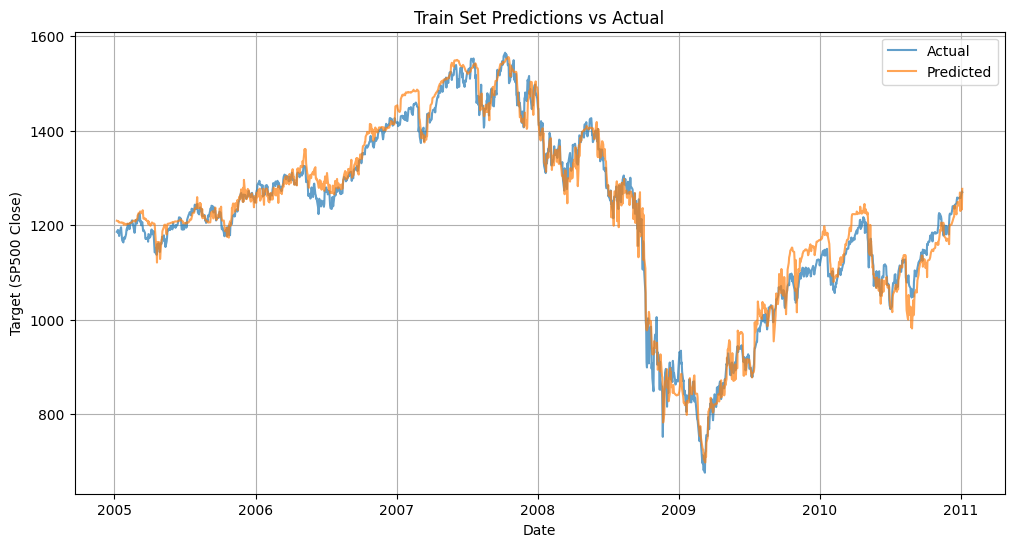

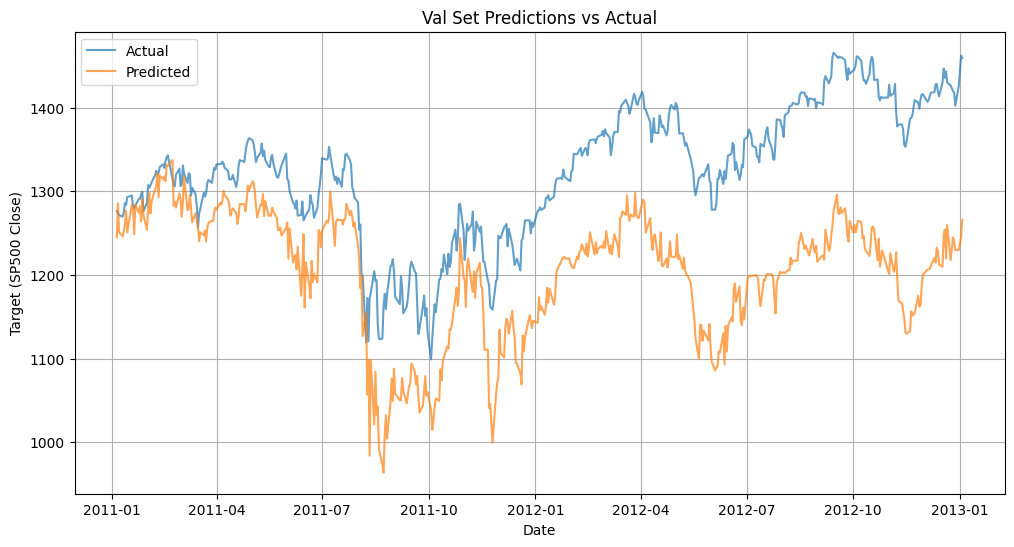

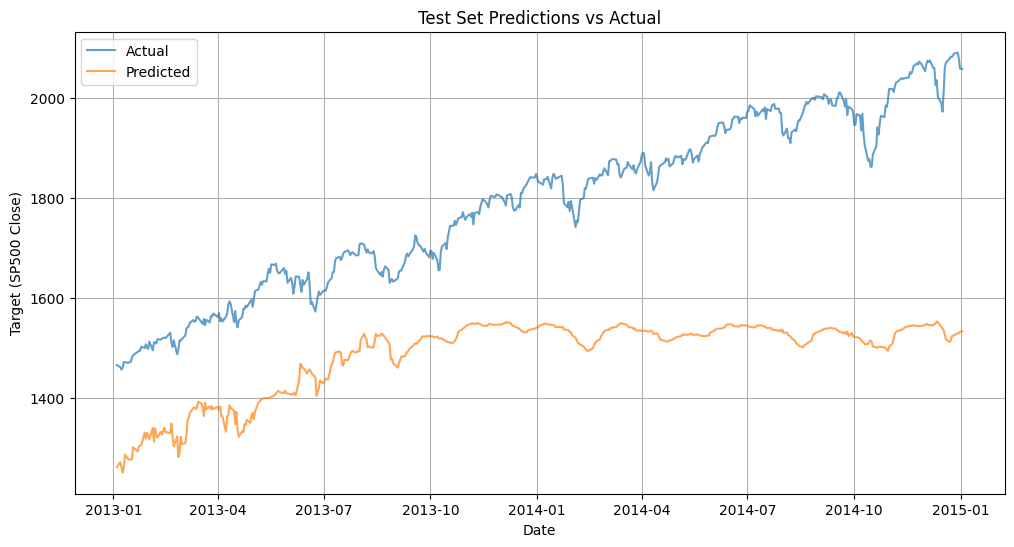

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# Plot test predictions vs actual values
plt.plot(dates_train, y_train, label="Actual", alpha=0.7)
plt.plot(dates_train, train_predictions, label="Predicted", alpha=0.7)

plt.title("Train Set Predictions vs Actual")
plt.xlabel("Date")
plt.ylabel("Target (SP500 Close)")
plt.legend()
plt.grid()
plt.show()
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# Plot test predictions vs actual values
plt.plot(dates_val, y_val, label="Actual", alpha=0.7)
plt.plot(dates_val, val_predictions, label="Predicted", alpha=0.7)

plt.title("Val Set Predictions vs Actual")
plt.xlabel("Date")
plt.ylabel("Target (SP500 Close)")
plt.legend()
plt.grid()
plt.show()

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# Plot test predictions vs actual values
plt.plot(dates_test, y_test, label="Actual", alpha=0.7)
plt.plot(dates_test, test_predictions, label="Predicted", alpha=0.7)

plt.title("Test Set Predictions vs Actual")
plt.xlabel("Date")
plt.ylabel("Target (SP500 Close)")
plt.legend()
plt.grid()
plt.show()
